# Face Face Recognition Sytem

In [79]:
import os
import cv2
import numpy as np
import pandas as pd

from insightface.app import FaceAnalysis

In [80]:
# configure face analysis
faceapp = FaceAnalysis(name='buffalo_sc',
                       root='insightface_model',
                       providers=['CPUExecutionProvider'])

faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)
# warning: don't set det_thresh < 0.3

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/buffalo_sc/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model/models/buffalo_sc/w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [81]:
#faceapp.get()

#### Extract Facial Features and labels

In [82]:
import re # regular expression

In [83]:
def clean_name(string):
    # Allow only A-Z a-z
    string = re.sub(r'[^A-Za-z]',' ',string)
    string = string.title()
    return string

In [84]:
person_info = []
listdir = os.listdir(path='images')
for folder_name in listdir:
    role, name = folder_name.split('-')
    name = clean_name(name)
    role = clean_name(role)
    #print('Role =',role,end='\t')
    #print('Name =', name)
    
    # path of each image in respective folder
    img_files = os.listdir(path= f'images/{folder_name}')
    for file in img_files:
        path = f'./images/{folder_name}/{file}'
        # step-1: read the image
        img_arr = cv2.imread(path)      
        
        # step-2: get the info
        result = faceapp.get(img_arr,max_num=1) # return list
        
        if len(result) > 0:
            # step-3: extract facial embedding
            res = result[0]
            embedding = res['embedding']
            # step-4: save all info name, role, embedding in a list
            person_info.append([name, role, embedding])

In [85]:
dataframe = pd.DataFrame(person_info,columns=['Name','Role','Facial_Features'])
dataframe # store in redis

,Name,Role,Facial_Features
0,Barack Obama,Teacher,"[0.86777174, -0.26744556, 0.070753574, -0.1441..."
1,Barack Obama,Teacher,"[1.6967499, -0.9942385, -0.22416791, -1.750138..."
2,Barack Obama,Teacher,"[2.2778594, -1.3971009, 1.563462, -1.480012, 0..."
3,Barack Obama,Teacher,"[-0.06546601, 0.015238434, -0.8531919, -0.3292..."
4,Barack Obama,Teacher,"[0.33165705, -1.2775117, 0.40062296, -1.360398..."
...,...,...,...
1316,Om,Student,"[2.0942419, -0.13652273, -0.5567631, -0.948763..."
1317,Om,Student,"[2.1160114, -1.2098573, 0.016185403, -1.432099..."
1318,Om,Student,"[0.6337966, -0.7781502, -0.06806761, -2.225211..."
1319,Om,Student,"[1.5285153, -0.91408205, -0.28689045, -1.41100..."


## Inference

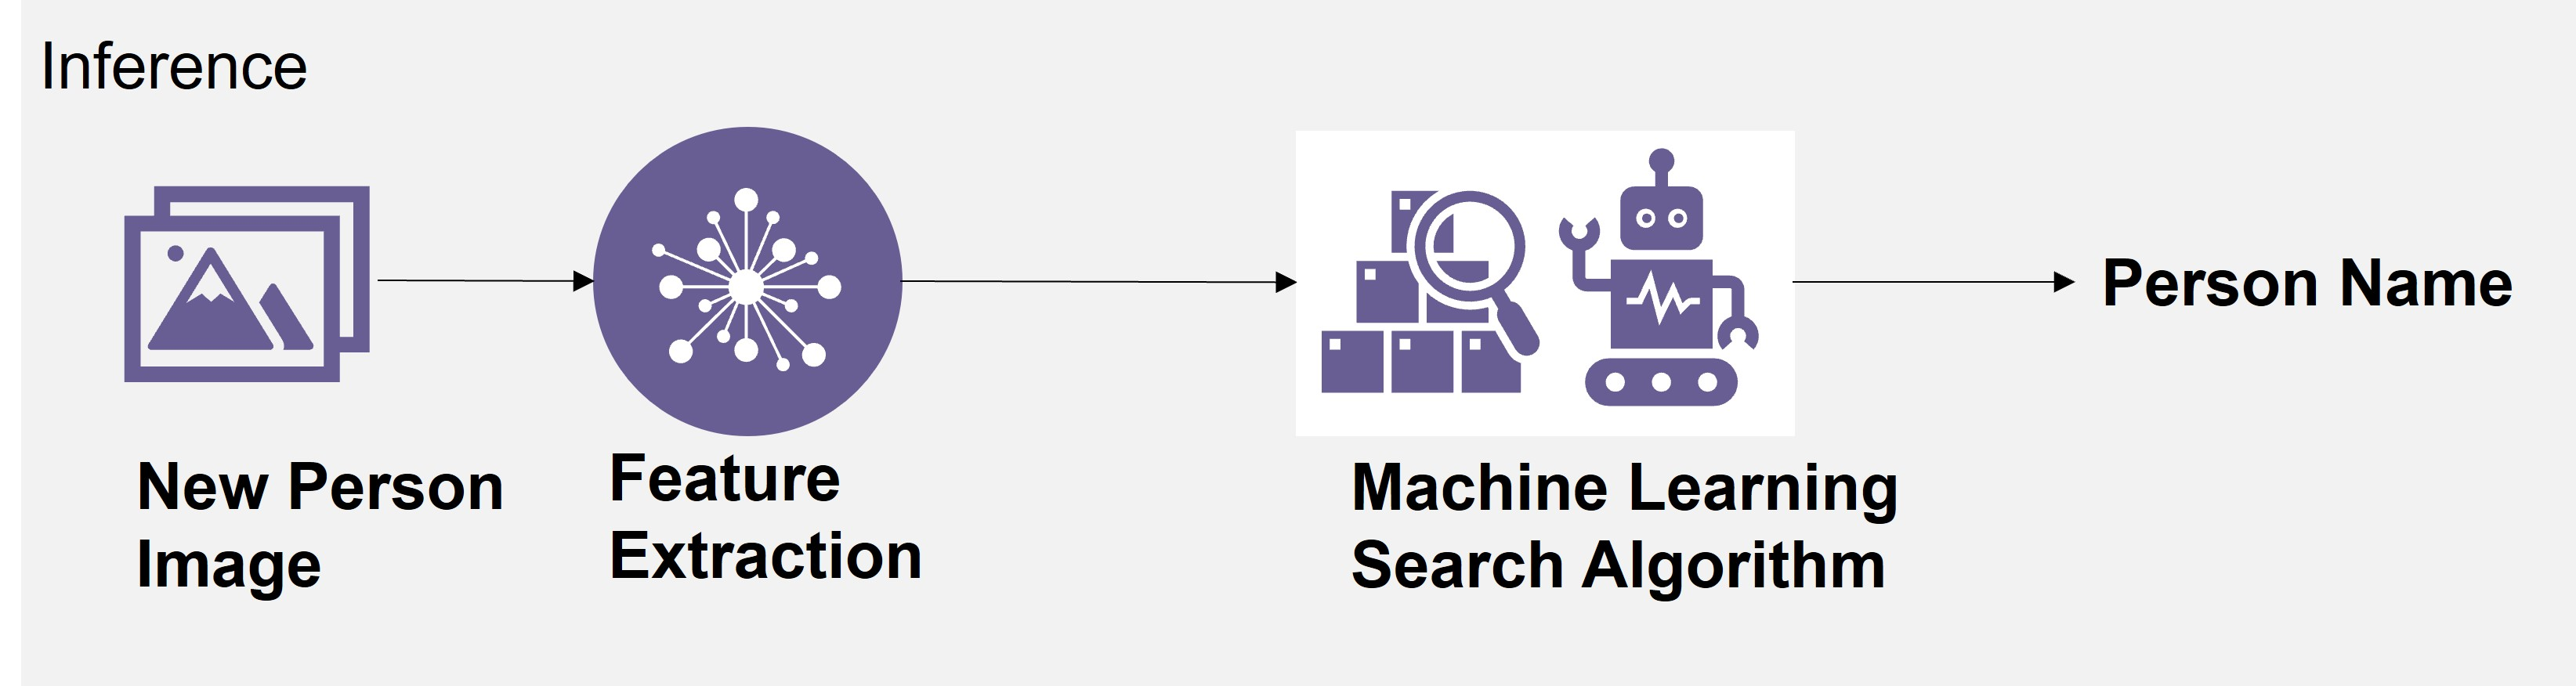

#### step-1: read image

In [86]:
# read test image
img_test = cv2.imread('test_images/test_2.jpeg')
cv2.imshow('test image',img_test)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### step -2: Extract Feature

In [87]:
res_test = faceapp.get(img_test,max_num=0)
for i, rt in enumerate(res_test):
    print('current loop =',i)
    bbox = rt['bbox'].astype(int)
    score = int(rt['det_score']*100)
    embed_test = rt['embedding']
    

current loop = 0


In [88]:
# consider only one sample
len(embed_test)

512

In [89]:
embed_test

array([-1.0785792 , -1.1072034 , -1.2359006 , -1.1190412 ,  1.6916196 ,
        1.2588973 , -0.42485118,  1.2528377 ,  1.9024427 ,  1.1879563 ,
       -2.245672  ,  2.0354257 , -0.16842383,  0.53057927,  0.3002857 ,
       -0.21257977,  0.30562732, -1.0242331 ,  0.2390659 ,  1.2245306 ,
       -0.31446567, -1.1225426 ,  2.4335976 ,  1.0288796 ,  0.61265826,
       -1.2186726 ,  1.4719696 , -0.37878817, -1.131981  ,  1.242806  ,
        1.1628733 ,  0.49313635,  0.9685552 ,  0.03850125,  0.4086311 ,
       -0.41302395,  0.01802629,  0.35701615,  0.9127355 , -0.1344508 ,
       -1.5695534 ,  1.4075115 ,  0.9529414 , -0.38528663,  0.0879333 ,
       -0.47209302, -0.20682615,  1.1180975 ,  0.775297  , -0.74925303,
       -2.0977914 ,  0.9927367 , -1.8607546 , -2.064167  , -0.88531   ,
       -0.03283212,  2.2557967 ,  0.2447021 , -0.39092302, -1.2569759 ,
       -0.822357  ,  0.22203101,  0.57044363,  0.37372676, -1.178931  ,
        0.8613459 ,  0.0827034 ,  0.71688426,  1.316746  ,  0.48

#### Algorithm

In [90]:
X_list =  dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)

In [91]:
X.shape

(1321, 512)

In [92]:
from sklearn.metrics import pairwise

In [93]:
y = embed_test.reshape(1,512) # 1 x 512

equlidean_distance = pairwise.euclidean_distances(X,y)
manhattan_distance = pairwise.manhattan_distances(X,y)
cosine_similar = pairwise.cosine_similarity(X,y)

In [94]:
data_search = dataframe.copy()
data_search['equlidean'] = equlidean_distance
data_search['manhattan'] = manhattan_distance
data_search['cosine'] = cosine_similar

In [95]:
data_search.head(2)

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Barack Obama,Teacher,"[0.86777174, -0.26744556, 0.070753574, -0.1441...",35.685818,644.639499,-0.095821
1,Barack Obama,Teacher,"[1.6967499, -0.9942385, -0.22416791, -1.750138...",32.884262,589.943155,-0.134625


In [96]:
import matplotlib.pyplot as plt

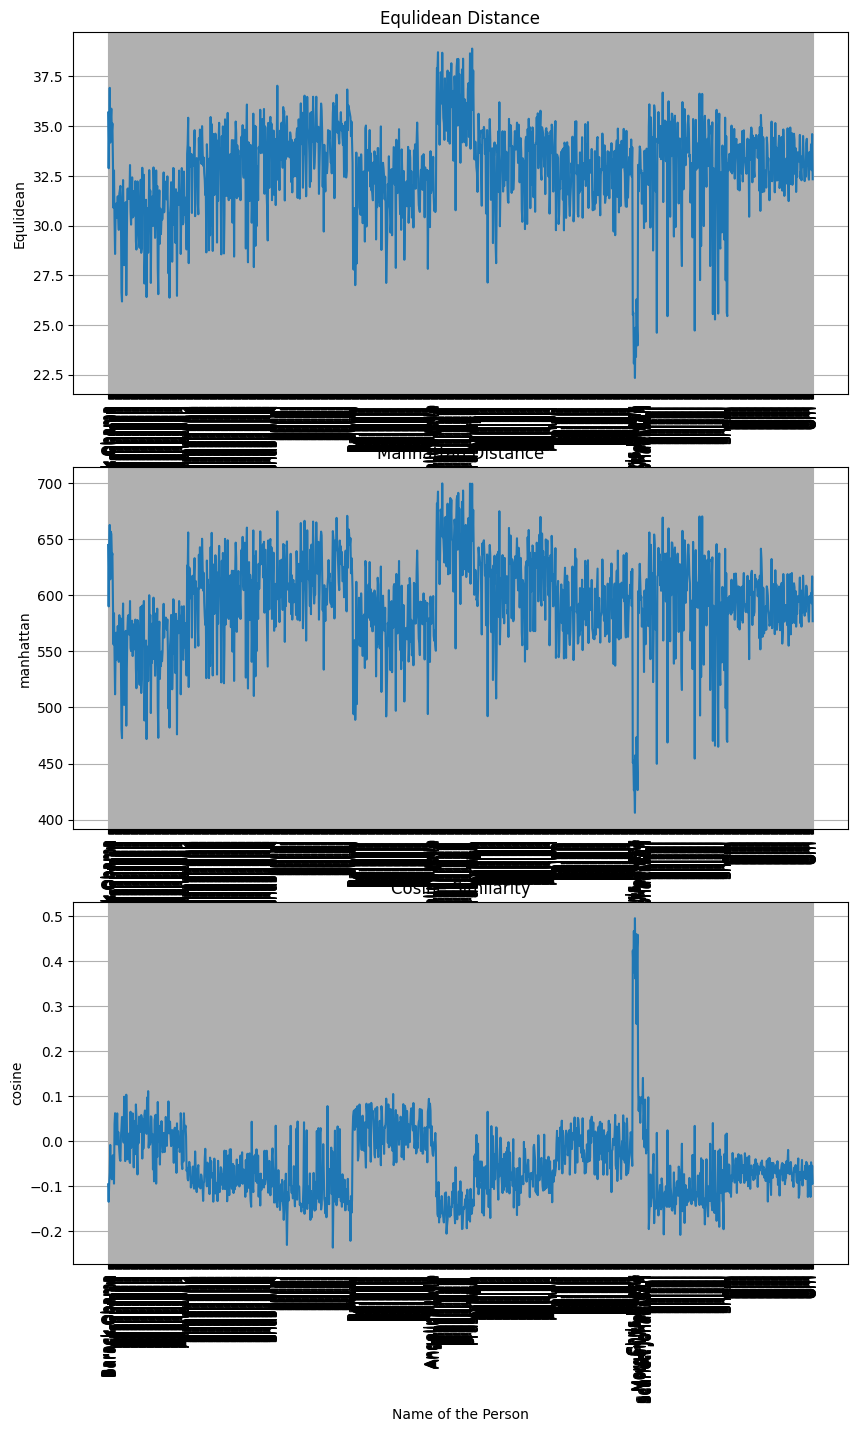

In [97]:
plt.figure(figsize=(10,16))
plt.subplot(3,1,1)
plt.plot(data_search['equlidean'],)
plt.xticks(ticks=list(range(len(data_search['equlidean']))),
           labels=data_search['Name'],rotation=90)
plt.xlabel('Name of the Person')
plt.ylabel('Equlidean')
plt.title('Equlidean Distance')
plt.grid()

plt.subplot(3,1,2)
plt.plot(data_search['manhattan'],)
plt.xticks(ticks=list(range(len(data_search['manhattan']))),
           labels=data_search['Name'],rotation=90)
plt.xlabel('Name of the Person')
plt.ylabel('manhattan')
plt.title('Manhattan Distance')
plt.grid()


plt.subplot(3,1,3)
plt.plot(data_search['cosine'],)
plt.xticks(ticks=list(range(len(data_search['cosine']))),
           labels=data_search['Name'],rotation=90)
plt.xlabel('Name of the Person')
plt.ylabel('cosine')
plt.title('Cosine Similarity')
plt.grid()


plt.show()

### Identify the Person using Equlidean Distance

In [98]:
d_eq_optimal = 25

In [99]:
datafilter = data_search.query(f'equlidean < {d_eq_optimal}')
datafilter.reset_index(drop=True,inplace=True)

if len(datafilter) > 0:
    argmin = datafilter['equlidean'].argmin()
    name , role = datafilter.loc[argmin][['Name','Role']]
    
else:
    name = 'Unknown'
    role = 'Unknown'

In [100]:
print(name, role)

Chris Evans Student


### Identify the Person using Manhattan Distance

In [101]:
d_man_optimal = 450

In [102]:
datafilter = data_search.query(f'manhattan < {d_man_optimal}')
datafilter.reset_index(drop=True,inplace=True)

if len(datafilter) > 0:
    argmin = datafilter['manhattan'].argmin()
    name_man , role_man = datafilter.loc[argmin][['Name','Role']]
    
else:
    name_man = 'Unknown'
    role_man = 'Unknown'

In [103]:
print(name, role)

Chris Evans Student


### Identify the Person using Cosine Similarity

In [104]:
S_opt = 0.4

In [105]:
datafilter = data_search.query(f'cosine > {S_opt}')
datafilter.reset_index(drop=True,inplace=True)

if len(datafilter) > 0:
    argmax = datafilter['cosine'].argmax()
    name_cos , role_cos = datafilter.loc[argmax][['Name','Role']]
    
else:
    name_cos = 'Unknown'
    role_cos = 'Unknown'

In [106]:
print(name_cos, role_cos)

Chris Evans Student


In [107]:
datafilter

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Chris Evans,Student,"[1.7492037, -2.1218047, -0.15239683, -0.905721...",25.514286,450.670632,0.423421
1,Chris Evans,Student,"[1.3108518, -2.0901625, -1.0368991, -1.7980283...",23.064388,426.207356,0.466915
2,Chris Evans,Student,"[0.5908872, -1.4150394, -0.6726931, -1.3109738...",22.335032,406.105140,0.495242
3,Chris Evans,Student,"[0.35467637, -0.6975621, -0.30049777, -1.91148...",23.396021,427.879582,0.460184
4,Chris Evans,Student,"[0.44940907, -1.631388, -0.950971, -1.5428777,...",24.786196,450.061264,0.430181
5,Chris Evans,Student,"[0.858841, -1.1002164, -0.7700131, -1.491781, ...",23.973530,426.329307,0.458686


### Identify Multiple Person in an Image

In [108]:
def ml_search_algorithm(dataframe,feature_column,test_vector,
                        name_role=['Name','Role'],thresh=0.5):
    """
    cosine similarity base search algorithm
    """
    # step-1: take the dataframe (collection of data)
    dataframe = dataframe.copy()
    # step-2: Index face embeding from the dataframe and convert into array
    X_list = dataframe[feature_column].tolist()
    x = np.asarray(X_list)
    
    # step-3: Cal. cosine similarity
    similar = pairwise.cosine_similarity(x,test_vector.reshape(1,-1))
    similar_arr = np.array(similar).flatten()
    dataframe['cosine'] = similar_arr

    # step-4: filter the data
    data_filter = dataframe.query(f'cosine >= {thresh}')
    if len(data_filter) > 0:
        # step-5: get the person name
        data_filter.reset_index(drop=True,inplace=True)
        argmax = data_filter['cosine'].argmax()
        person_name, person_role = data_filter.loc[argmax][name_role]
        
    else:
        person_name = 'Unknown'
        person_role = 'Unknown'
        
    return person_name, person_role

In [118]:
test_image = cv2.imread('test_images/test_10.jpg')
cv2.imshow('test image',test_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [110]:
# step-1: take the test image and apply to insight face
results = faceapp.get(test_image)
test_copy = test_image.copy()
# step-2: use for loop and extract each embedding and pass to ml_search_algorithm

for res in results:
    x1, y1, x2, y2 = res['bbox'].astype(int)
    embeddings = res['embedding']
    person_name, person_role = ml_search_algorithm(dataframe_compress,
                                                   'Facial_Features',
                                                   test_vector=embeddings,
                                                   name_role=['Name','Role'],
                                                   thresh=0.5)
    if person_name == 'Unknown':
        color =(0,0,255) # bgr
    else:
        color = (0,255,0)
        
        
    cv2.rectangle(test_copy,(x1,y1),(x2,y2),color)
    
    text_gen = person_name
    cv2.putText(test_copy,text_gen,(x1,y1),cv2.FONT_HERSHEY_DUPLEX,0.7,color,2)
    
    
cv2.imshow('test image',test_copy)
cv2.waitKey()
cv2.destroyAllWindows()

### Compressing my dataset

In [117]:
dataframe_compress = dataframe.groupby(by=['Name','Role']).mean()
dataframe_compress.reset_index(inplace=True)
dataframe_compress

,Name,Role,Facial_Features
0,Aashutosh,Student,"[-0.036052156, -0.308354, 0.046328023, 1.67468..."
1,Angelina Jolie,Student,"[0.43222705, 1.0748217, -0.12857997, -1.833244..."
2,Ashish,Student,"[0.1670312, -1.149379, 0.41227043, 1.351386, 0..."
3,Barack Obama,Teacher,"[0.94860345, -0.5583488, 0.0948473, -1.2796339..."
4,Chris Evans,Student,"[0.72012293, -1.4683535, -0.7775747, -1.460268..."
5,Morgan Freeman,Teacher,"[0.4857933, -0.6193172, -0.4072945, 1.068671, ..."
6,Om,Student,"[1.7085426, -0.7759952, -0.22737093, -1.247895..."
7,Prashraya,Student,"[-0.8314713, -0.336633, 0.79281545, -0.1401238..."
8,Rajan,Student,"[-0.24466082, -1.858166, -1.2051669, 0.7937251..."
9,Rajesh,Student,"[0.76098776, -0.24004512, -1.8921047, -1.49513..."


#### convert dataframe into array and save in numpy zip format

In [119]:
xvalues = dataframe_compress.values

In [120]:
col_name = np.array(dataframe_compress.columns)
col_name

array(['Name', 'Role', 'Facial_Features'], dtype=object)

In [121]:
np.savez('dataframe_students_teacher.npz',xvalues,col_name)

In [122]:
# load the numpy zip
file_np = np.load('dataframe_students_teacher.npz',allow_pickle=True)
file_np.files

['arr_0', 'arr_1']

In [123]:
pd.DataFrame(file_np['arr_0'],columns=file_np['arr_1'])

,Name,Role,Facial_Features
0,Aashutosh,Student,"[-0.036052156, -0.308354, 0.046328023, 1.67468..."
1,Angelina Jolie,Student,"[0.43222705, 1.0748217, -0.12857997, -1.833244..."
2,Ashish,Student,"[0.1670312, -1.149379, 0.41227043, 1.351386, 0..."
3,Barack Obama,Teacher,"[0.94860345, -0.5583488, 0.0948473, -1.2796339..."
4,Chris Evans,Student,"[0.72012293, -1.4683535, -0.7775747, -1.460268..."
5,Morgan Freeman,Teacher,"[0.4857933, -0.6193172, -0.4072945, 1.068671, ..."
6,Om,Student,"[1.7085426, -0.7759952, -0.22737093, -1.247895..."
7,Prashraya,Student,"[-0.8314713, -0.336633, 0.79281545, -0.1401238..."
8,Rajan,Student,"[-0.24466082, -1.858166, -1.2051669, 0.7937251..."
9,Rajesh,Student,"[0.76098776, -0.24004512, -1.8921047, -1.49513..."


### [END](https://www.udemy.com/user/freeai-space/)
---